# Plot 3D houses in Belgium

## Address

In [1]:
address = "Molenstraat 76 1840 Londerzeel"

In [2]:
import time

# Log the start time
start_time = time.time()

In [3]:
#address = input("Enter an address in Belgium:")

## Import libraries

In [4]:
import os
import pandas as pd

from glob import glob  
from natsort import natsorted, ns

import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import rasterio  
from rasterio.plot import show
from pyproj import Transformer
from rasterio.windows import Window
import rioxarray 

import imageio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal
from mayavi import mlab

import webbrowser
from IPython.display import Image

%matplotlib inline

In [5]:
flandre_path = '/Users/adamtky/Desktop/BeCode/3. Project/Project 3 - 3D Houses'

In [6]:
wallonie_path = '/Volumes/Seagate Expansion Drive/Project 3 - 3D Houses_Wallonie'

### Search all tifs and sort files on laptop ( Flandre & Brussels )

In [7]:
def tif_file(path):
    
    tif_file =[]
    
    # using glob library to get all the file with .tif
    files = glob(path,recursive = True) 
    for file in files: 
        tif_file.append(file)
        
    # sort files with number in the file (ascending order) using natsorted library
    tif_file = natsorted(tif_file, alg=ns.IGNORECASE)     
    return tif_file

In [8]:
path = './DSM/**/*.tif'
DSM_tif = tif_file(path)
DSM_tif[:3]

['./DSM/DHMVIIDSMRAS1m_k1/GeoTIFF/DHMVIIDSMRAS1m_k1.tif',
 './DSM/DHMVIIDSMRAS1m_k2/GeoTIFF/DHMVIIDSMRAS1m_k2.tif',
 './DSM/DHMVIIDSMRAS1m_k3/GeoTIFF/DHMVIIDSMRAS1m_k3.tif']

In [9]:
path = './DTM/**/*.tif'
DTM_tif = tif_file(path)
DTM_tif[:3]

['./DTM/DHMVIIDTMRAS1m_k1/GeoTIFF/DHMVIIDTMRAS1m_k1.tif',
 './DTM/DHMVIIDTMRAS1m_k2/GeoTIFF/DHMVIIDTMRAS1m_k2.tif',
 './DTM/DHMVIIDTMRAS1m_k3/GeoTIFF/DHMVIIDTMRAS1m_k3.tif']

### Search all tifs and sort files on hard drive ( Wallanie )

In [10]:
os.chdir(wallonie_path)

In [11]:
path_wal = './DSM/*.tif'
DSM_tif_wal = tif_file(path_wal)
DSM_tif_wal

['./DSM/dsm_1.tif',
 './DSM/dsm_2.tif',
 './DSM/dsm_3.tif',
 './DSM/dsm_4.tif',
 './DSM/dsm_5.tif']

In [12]:
path_wal = './DTM/*.tif'
DTM_tif_wal = tif_file(path_wal)
DTM_tif_wal

['./DTM/dtm_1.tif',
 './DTM/dtm_2.tif',
 './DTM/dtm_3.tif',
 './DTM/dtm_4.tif',
 './DTM/dtm_5.tif']



### Geocoding - single address

In [13]:
# to get the longtitude and latitude of the address entered & plot address on a map

def lat_long(address):
    
    # to get the longtitude and latitude 
    
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address)
    house_lat_long = [location.latitude, location.longitude]
    return house_lat_long

def house_map(func):
    
    # to plot address 
    
    house_map = folium.Map(location=func,zoom_start=150)
    folium.Marker(location=func,popup=lat_long(address)).add_to(house_map)
    #house_map.save(address+".html")
    return house_map 

house_map(lat_long(address))

### Convert longtitude & latitude 

In [14]:
# longtitude and latitude of the address entered
lat,lon = lat_long(address)
lat,lon

(51.0037256, 4.2978885)

In [15]:
def transform(lon, lat):
    
    # transform to Belgium 'EPSG:31370' coordinate
    transformer = Transformer.from_crs("EPSG:4326", crs_to = 'EPSG:31370' ,always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    print(f'longtitude:{xx} latitude:{yy}' )
    
    return xx,yy

In [16]:
# coordinate EPSG:31370
xx,yy = transform(lon, lat)

longtitude:145025.89798251074 latitude:188169.89792548958


### Using CSV to locate coordinate EPSG:31370

In [17]:
address_path = '/Users/adamtky/Desktop/BeCode/3. Project/Project 3 - 3D Houses/Data/Belgium_Address.csv'

In [18]:
def get_coordinate(path,address):
    
    index = []
    
    df = pd.read_csv(path)
    
    for i in range(df.shape[0]):

        if df['Address'][i] == address :
            index.append(i)
            break
        continue

    xx, yy = df['EPSG:31370_x'][index][index[0]] ,df['EPSG:31370_y'][index][index[0]] 

    lat, lon = df['EPSG:4326_lat'][index][index[0]] ,df['EPSG:4326_lon'][index][index[0]] 
    
    return (xx, yy) , (lat, lon)

In [19]:
(xx, yy) , (lat, lon) = get_coordinate(address_path,address)

### Locate tif for given longtitude & latitude

In [20]:
os.chdir(flandre_path)

In [21]:
# create all bounding box from tifs

def bounds(tifs):
    
    bounds = []
    
    for i in tifs:
        src = rasterio.open(i)
        bounds.append(src.bounds)
        
    return  bounds 

In [22]:
src_bounds_flb = bounds(DSM_tif)

In [23]:
src_bounds_flb[:3]

[BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0),
 BoundingBox(left=162000.0, bottom=238000.0, right=194000.0, top=250000.0),
 BoundingBox(left=194000.0, bottom=238000.0, right=206000.0, top=248000.0)]

In [24]:
os.chdir(wallonie_path)

In [25]:
src_bounds_wal = bounds(DSM_tif_wal)

In [26]:
src_bounds_wal

[BoundingBox(left=130000.00000000211, bottom=133999.99999999837, right=196000.0000000021, top=167999.99999999837),
 BoundingBox(left=42000.0, bottom=69999.99999999927, right=168000.0, top=167999.99999999927),
 BoundingBox(left=192000.0000000026, bottom=91999.99999999895, right=296000.00000000256, top=167999.99999999895),
 BoundingBox(left=192000.00000000143, bottom=19999.999999999403, right=270000.0000000014, top=125999.9999999994),
 BoundingBox(left=144000.000000004, bottom=51999.9999999993, right=224000.000000004, top=149999.9999999993)]

In [27]:
# check which tif contains the location in DSM

def check_DSM_flb(xx,yy):
    
    scr_path = []

    for i,bound in enumerate(src_bounds_flb,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):

            scr_path.append('./DSM/DHMVIIDSMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k'+ str(i) + '.tif')  

            print('The house is in this tif :', 'DHMVIIDSMRAS1m_k' + str(i) + '.tif')
        else:
            None
            
    return scr_path

In [28]:
dsm_path_flb = check_DSM_flb(xx,yy)

The house is in this tif : DHMVIIDSMRAS1m_k23.tif


In [29]:
dsm_path_flb

['./DSM/DHMVIIDSMRAS1m_k23/GeoTIFF/DHMVIIDSMRAS1m_k23.tif']

In [30]:
# check which tif contains the location in DSM

def check_DSM_wal(xx,yy):

    scr_path = []

    for i,bound in enumerate(src_bounds_wal,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):

            scr_path.append('/Volumes/Seagate Expansion Drive/Project 3 - 3D Houses_Wallonie/DSM/dsm_'+ str(i) + '.tif')  

            print('The house is in this tif :', '/Volumes/Seagate Expansion Drive/Project 3 - 3D Houses_Wallonie/DSM/dsm_' + str(i) + '.tif')
            
    return scr_path

In [31]:
dsm_path_wal = check_DSM_wal(xx,yy)

In [32]:
dsm_path_wal

[]

In [33]:
# check which tif contains the location in DTM


def check_DTM_flb(xx,yy):
    
    scr_path = []

    for i,bound in enumerate(src_bounds_flb,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):

            scr_path.append('./DTM/DHMVIIDTMRAS1m_k'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k'+ str(i) + '.tif')  

            print('The house is in this tif :', 'DHMVIIDTMRAS1m_k' + str(i) + '.tif')
        else:
            None
            
    return scr_path

In [34]:
dtm_path_flb = check_DTM_flb(xx,yy)
dtm_path_flb

The house is in this tif : DHMVIIDTMRAS1m_k23.tif


['./DTM/DHMVIIDTMRAS1m_k23/GeoTIFF/DHMVIIDTMRAS1m_k23.tif']

In [35]:
# check which tif contains the location in DTM

def check_DTM_wal(xx,yy):

    scr_path = []

    for i,bound in enumerate(src_bounds_wal,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):

            scr_path.append('/Volumes/Seagate Expansion Drive/Project 3 - 3D Houses_Wallonie/DTM/dtm_'+ str(i) + '.tif')  

            print('The house is in this tif :', '/Volumes/Seagate Expansion Drive/Project 3 - 3D Houses_Wallonie/DTM/dtm_' + str(i) + '.tif')
            
    return scr_path

In [36]:
dtm_path_wal = check_DTM_wal(xx,yy)

### Clip the location of the house from tif

In [37]:
dsm_path = []

if not dsm_path_flb:
    dsm_path.append(dsm_path_wal[0])
    os.chdir(wallonie_path)
else:
    dsm_path.append(dsm_path_flb[0])
    os.chdir(flandre_path)

In [38]:
dtm_path = []

if not dtm_path_flb:
    dtm_path.append(dtm_path_wal[0])
    os.chdir(wallonie_path)
else:
    dtm_path.append(dtm_path_flb[0])
    os.chdir(flandre_path)

In [39]:
dsm_path

['./DSM/DHMVIIDSMRAS1m_k23/GeoTIFF/DHMVIIDSMRAS1m_k23.tif']

In [40]:
dtm_path

['./DTM/DHMVIIDTMRAS1m_k23/GeoTIFF/DHMVIIDTMRAS1m_k23.tif']

In [41]:
def clip_dsm(path,window_size:int):
 
    xds = rioxarray.open_rasterio(path,masked=True,chunks=True)
    
    # set window size
    n = window_size

    # create coordinates and geometries
    coor1,coor2 = [(xx-n),(yy+n)],[(xx+n),(yy+n)]

    coor3,coor4 = [(xx+n),(yy-n)] ,[(xx-n),(yy-n)]

    geometries = [ {'type': 'Polygon', 'coordinates': [[coor1,coor2, coor3,coor4,coor1 ]]}]

    # clip the image as per the geometries size
    clipped = xds.rio.clip(geometries)
    
    # change directory
    os.chdir(flandre_path)
    
    # save clip
    clip_dsm = clipped.rio.to_raster(address+"_clipped_dsm.tif",tiled=True, dtype="int32")

    return clipped.plot()

In [42]:
def clip_dtm(path,window_size:int):
 
    xds = rioxarray.open_rasterio(path,masked=True,chunks=True)
    
    # set window size
    n = window_size

    # create coordinates and geometries
    coor1,coor2 = [(xx-n),(yy+n)],[(xx+n),(yy+n)]

    coor3,coor4 = [(xx+n),(yy-n)] ,[(xx-n),(yy-n)]

    geometries = [ {'type': 'Polygon', 'coordinates': [[coor1,coor2, coor3,coor4,coor1 ]]}]

    # clip the image as per the geometries size
    clipped = xds.rio.clip(geometries)

    # change directory
    os.chdir(flandre_path)
    
    # save clip
    clip_dtm = clipped.rio.to_raster(address +"_clipped_dtm.tif",tiled=True, dtype="int32")

    return clipped.plot()

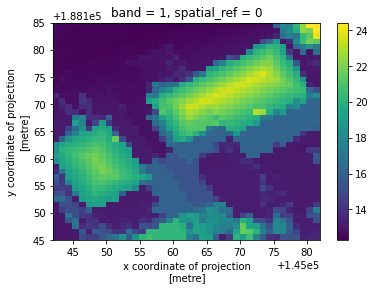

In [43]:
clip_dsm(dsm_path[0],20)

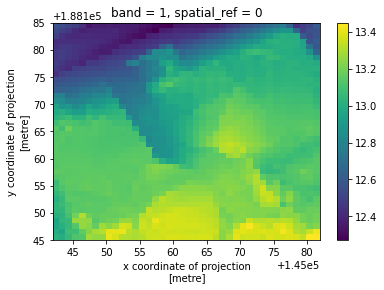

In [44]:
clip_dtm(dtm_path[0],20)

In [45]:
def chm_tif():
    
    # open the digital terrain model 
    with rasterio.open(address +'_clipped_dtm.tif') as src:
        lidar_dtm_im = src.read(1, masked=True)
        dtm_meta = src.profile
        
    # open the digital surface model 
    with rasterio.open(address +'_clipped_dsm.tif') as src:
        lidar_dsm_im = src.read(1, masked=True)
        dsm_meta = src.profile
    
    # calculate canopy height model
    lidar_chm = lidar_dsm_im - lidar_dtm_im
    
    # change directory
    os.chdir(flandre_path)
    
    # save chm clipped 
    with rasterio.open(address +'_clipped_chm.tif', 'w', **dsm_meta) as ff:
        ff.write(lidar_chm,1)
        
    chm_tif = address +'_clipped_chm.tif'
    
    return chm_tif

### Create 3D

In [46]:
def House_3D(tif,size:int,azim=215):

    chm = imageio.imread(tif)

    nx,ny = chm.shape

    x = np.linspace(0, size*2, nx)
    y = np.linspace(0, size*2, ny)

    yv,xv = np.meshgrid(x, y)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    chm3d=ax.plot_surface(xv,yv,chm,cmap='plasma',linewidth=0)
    ax.set_title('CHM(Canopy Height Model)')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Distance (m)')
    ax.set_zlabel('Elevation (m)')
    ax.view_init(azim=azim)
        
    fig.colorbar(chm3d, shrink=0.3, aspect=10);
    fig.savefig(address +'_3D.png', dpi=200) 
    
    return  plt.show()


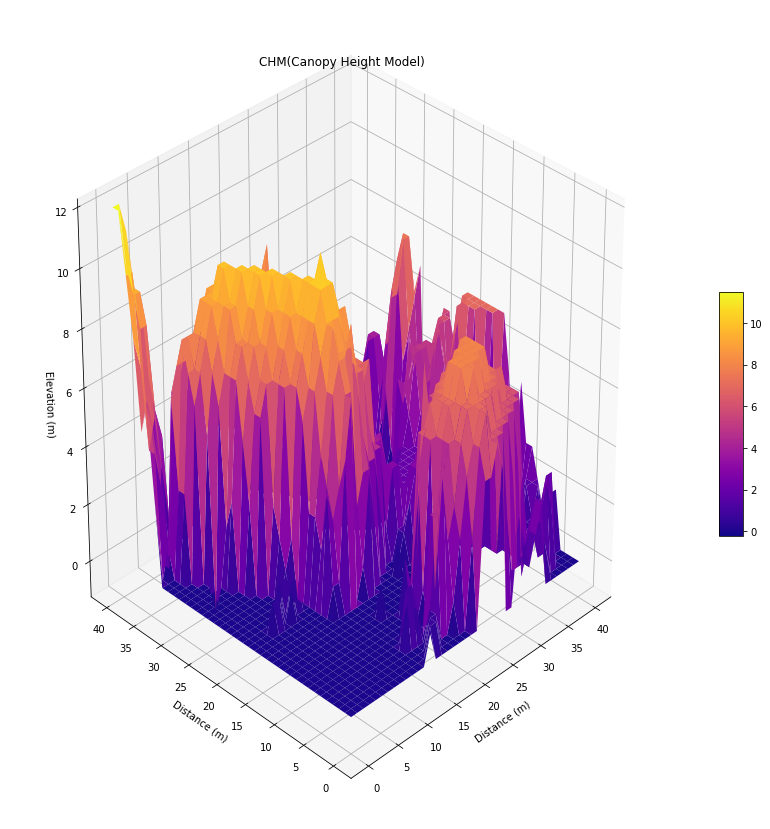

In [57]:
House_3D(chm_tif(),20,225)

In [48]:
# Log the end time
end_time = time.time()

print('Time taken for generating 3D house in seconds: ', end_time - start_time)

Time taken for generating 3D house in seconds:  50.596235036849976


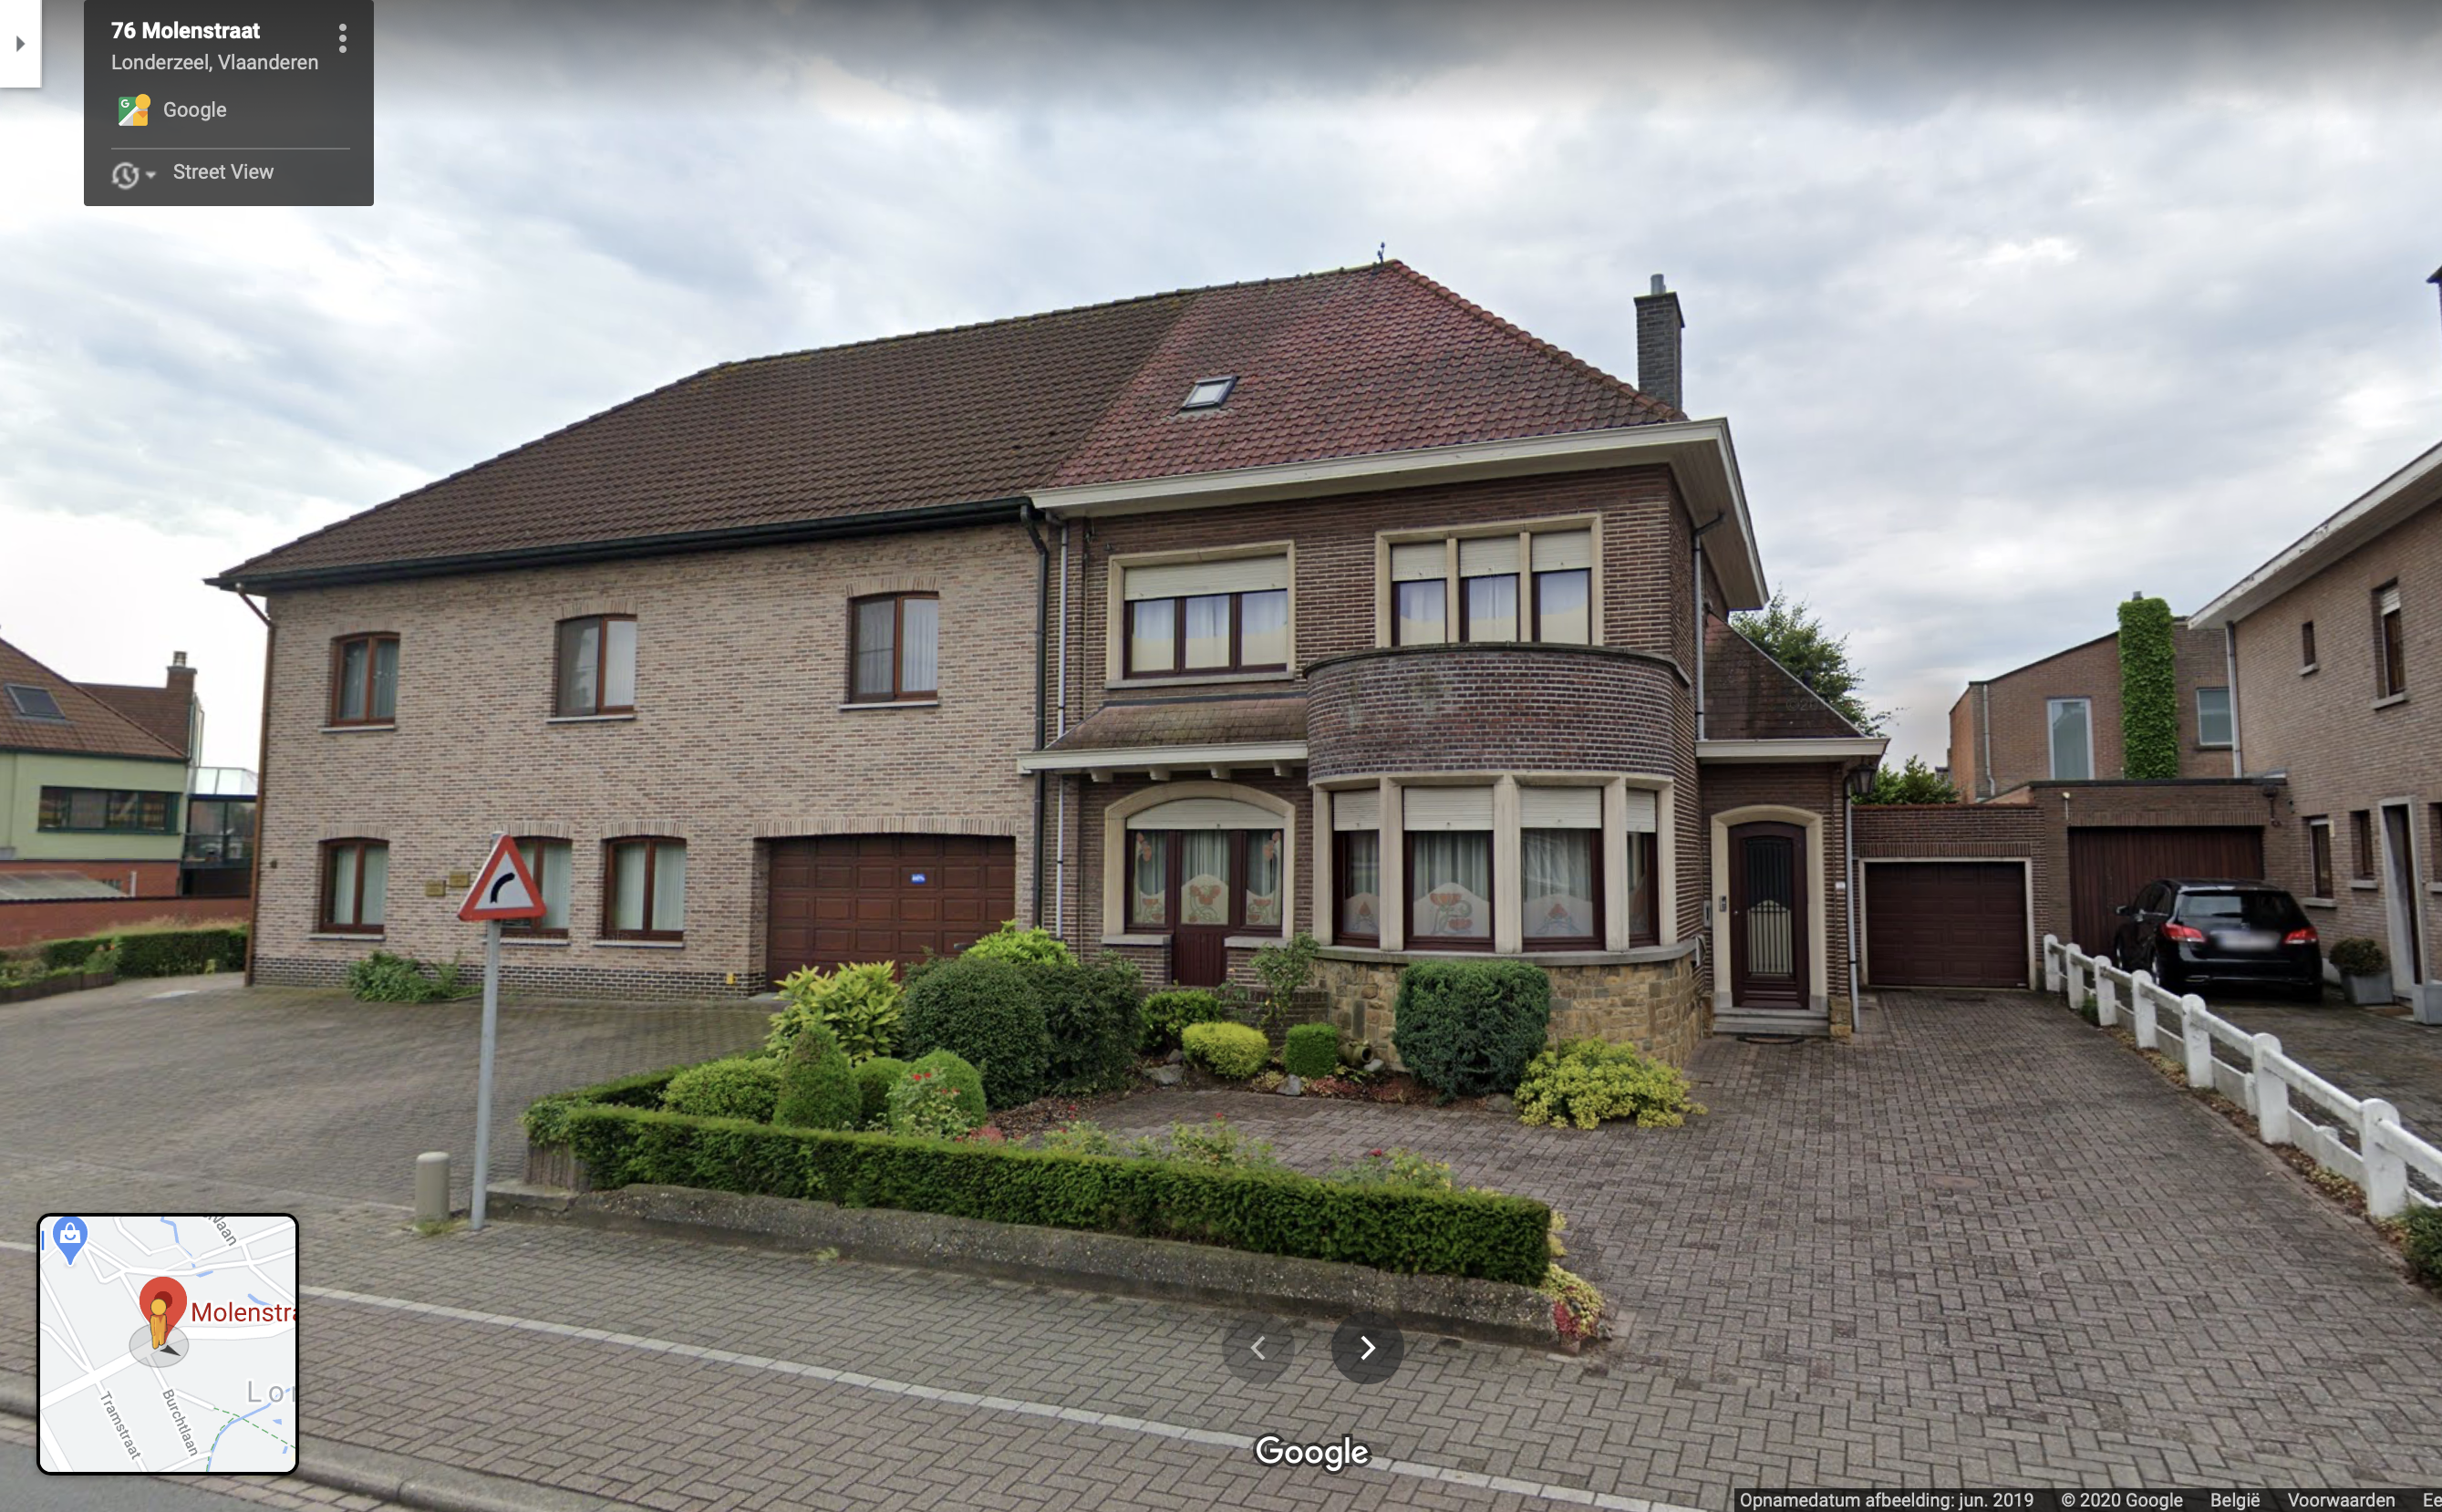

In [2]:
# compare google map image of the house
Image(address+".png")

In [53]:
# to view actual house on google map
url = 'https://www.google.com.my/maps/place/'+str(lat)+','+str(lon)
webbrowser.open(url)

True

In [58]:
# Plotting the CHM with Mayavi2

ds = gdal.Open(chm_tif())
data = ds.ReadAsArray()

data = data.astype(np.float32)

mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))

surf = mlab.surf(data)

mlab.show()

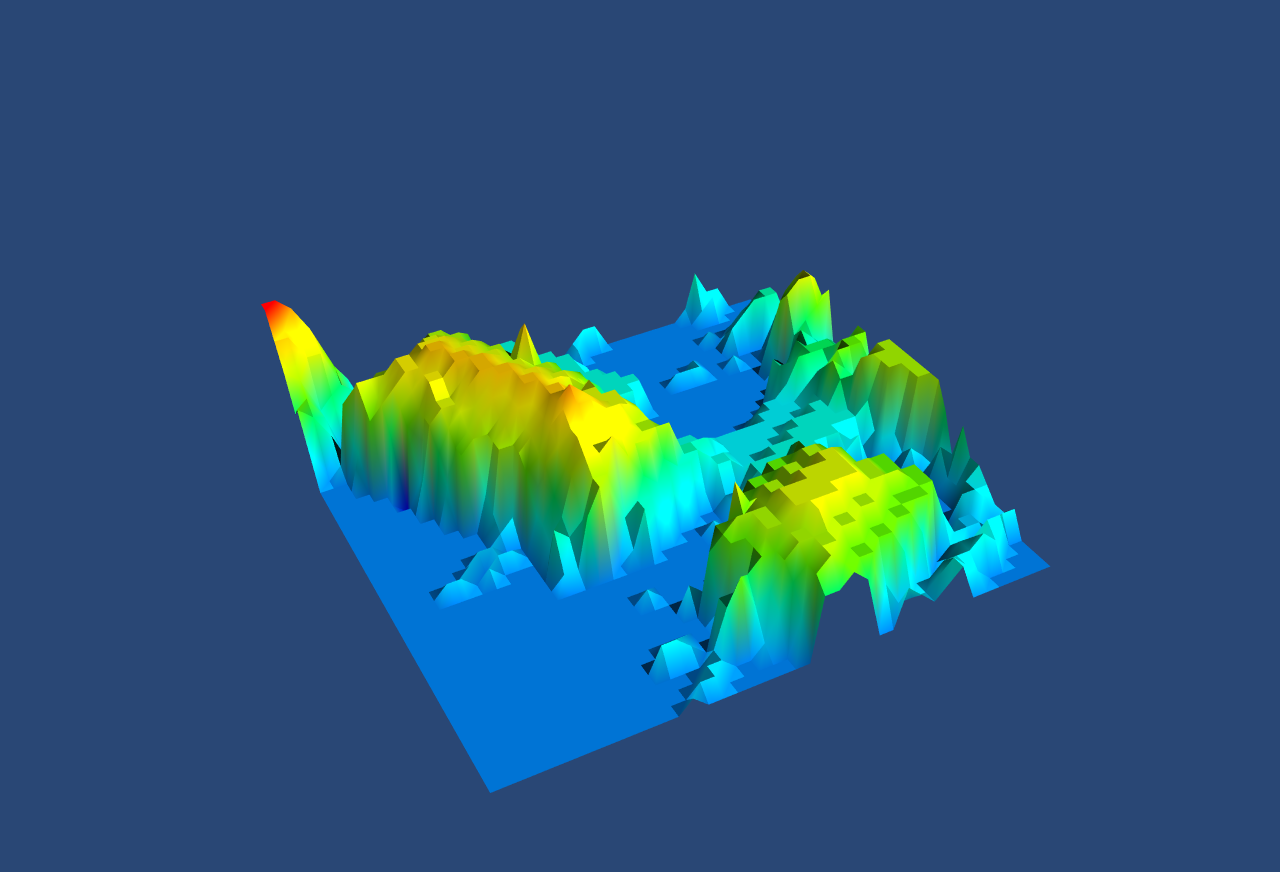

In [60]:
# mayavi image
Image(address+"_mayavi.png")